<a href="https://colab.research.google.com/github/technologicwoman/LLM-app/blob/main/IIS_ML_svm_seleccion_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción  a los Sistemas Inteligentes
# 2018-2
# Máquinas de vectores de soporte y selección de modelos

Definimos primero unas librerías y funciones que vamos a usar a durante la sesión:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize


# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def plot_labels(n_folds, n_classes, list_labels):
    ind = np.arange(n_folds)
    width = 0.15

    countings = []
    for labels in list_labels:
        labels = np.array(labels)
        countings.append([np.count_nonzero(labels == x) for x in range(n_classes)])

    class_bars = []
    for cls in range(n_classes):
        class_bars.append([l[cls] for l in countings])

    fig, ax = pl.subplots()
    i = 0
    for class_bar in class_bars:
        ax.bar(ind + width*i, class_bar, width, label='Clase '+str(i))
        i += 1

    ax.set_xticks(ind + 2*width / 3)
    ax.set_xticklabels(['Pliegue {}'.format(k) for k in range(n_folds)])
    pl.legend(loc="best")
    pl.title("Etiquetas")

# Máquinas de vectores de soporte

Las máquinas de vectores de soporte son un modelo de aprendizaje supervisado en el cual los ejemplos son representados en un nuevo espacio, de tal forma que aquellos ejemplos de diferentes categorías sea posible, en principio, separarlos linealmente. Considere el siguiente ejemplo de un conjunto de datos.

In [ ]:
from sklearn.datasets import make_circles, make_moons

np.random.seed(0)

X, y = make_circles(n_samples=1000, factor=.3, noise=.05)

Se trata de un conjunto de datos que no es linealmente separable

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


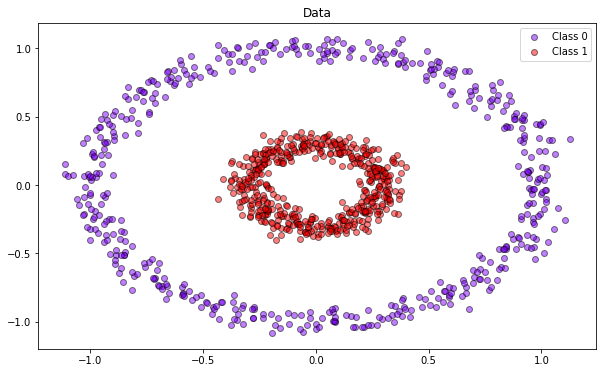

In [ ]:
pl.figure(figsize = (10, 6))
plot_data(X, y)

**¿Se pueden separar las clases con una función lineal?**

SVM  crea, implícitamente, un espacio de representación de mayor dimensionalidad en el cual podemos separar de forma clara nuestros datos. Por ejemplo:

<img src="https://drive.google.com/uc?export=view&id=1NuYvzWfEb_nOZ9pWbsycdQWiHhad5_BI">

Para el ejemplo anterior, podemos llevar los datos a un nuevo espacio donde las características corresponden al cuadrado de las características originales:

$$\begin{equation}
\begin{split}
\phi:& \mathbb{R}^2  & \longrightarrow & \mathbb{R}^2 \\
  & (x,y) & \longmapsto & (x^2,y^2)
\end{split}
\end{equation}$$

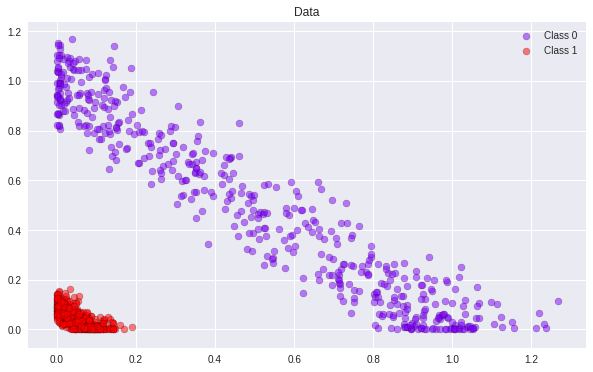

In [ ]:
X_square = X * X
pl.figure(figsize = (10, 6))
plot_data(X_square, y)

En este nuevo espacio de representación, es posible separar los datos con un discriminante lineal.

## Kernel trick

SVM usa una función conocida como kernel. Intuitivamente, esta función $k$ define qué tan parecidas son dos instancias del conjunto de datos. Formalmente, la función $k$ calcula el producto punto en el espacio de caracterísiticas donde se representarán los datos. Dependiendo del kernel, este espacio de características es de mayor dimensionalidad, y facilita la  definición de un "*hiperplano*" que separe los ejemplos de ambas características.

Existen varias opciones para las funciones de kernel. Primero vamos a cargar dos conjuntos de datos sobre los cuales vamos a comparar la superficie de decisión generada por cada tipo de kernel.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X_iris = iris.data[:,[0, 2]]
y_iris = iris.target
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris,
                                                                        y_iris,
                                                                        test_size=0.3,
                                                                        random_state=1)

X_moons, y_moons = make_moons(n_samples=600, noise=0.3, random_state=0)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons,
                                                                            y_moons,
                                                                            test_size=0.3,
                                                                            random_state=1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


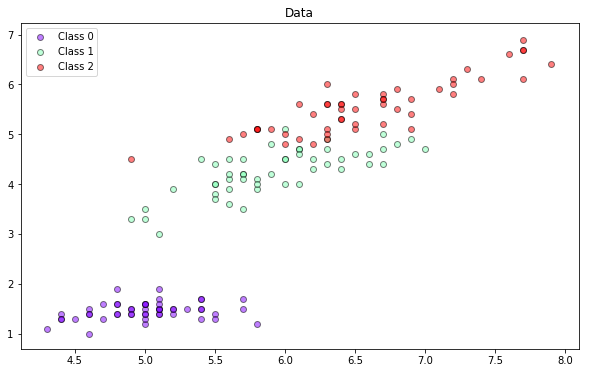

In [ ]:
pl.figure(figsize = (10, 6))
plot_data(X_iris, y_iris)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


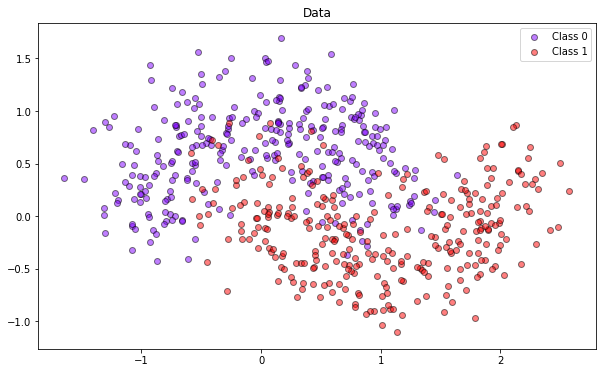

In [ ]:
pl.figure(figsize = (10, 6))
plot_data(X_moons, y_moons)

## Kernel Lineal

La función $k$ está definida como:
$$
k(x,y) = \langle x, y\rangle = xy'
$$

Esta implementación puede ser consultada a través de `sklearn.svm.LinearSVC`.

In [ ]:
from sklearn.svm import LinearSVC

linear_iris = LinearSVC()
linear_moons = LinearSVC()

linear_iris.fit(X_train_iris, y_train_iris)
linear_moons.fit(X_train_moons, y_train_moons);

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Ahora visualizamos los datos de ambos:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


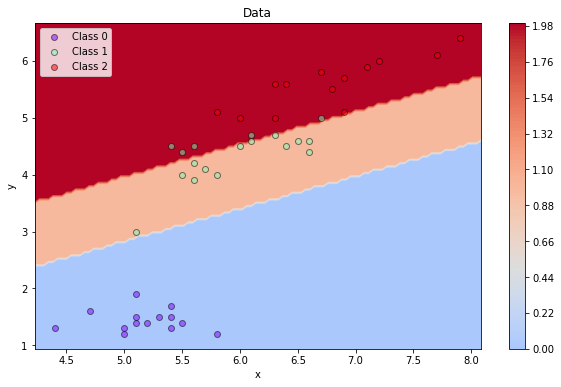

In [ ]:
pl.figure(figsize = (10, 6))
plot_decision_region(X_test_iris, gen_pred_fun(linear_iris))
plot_data(X_test_iris, y_test_iris)

El error en el conjunto de entrenamiento y prueba es el siguiente:

In [ ]:
print("Error en entrenamiento: {}".format(1-linear_iris.score(X_train_iris, y_train_iris)))
print("Error en prueba: {}".format(1-linear_iris.score(X_test_iris, y_test_iris)))

Error en entrenamiento: 0.04761904761904767
Error en prueba: 0.11111111111111116


Ahora hacemos los mismo para el conjunto de datos generado artificialmente:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


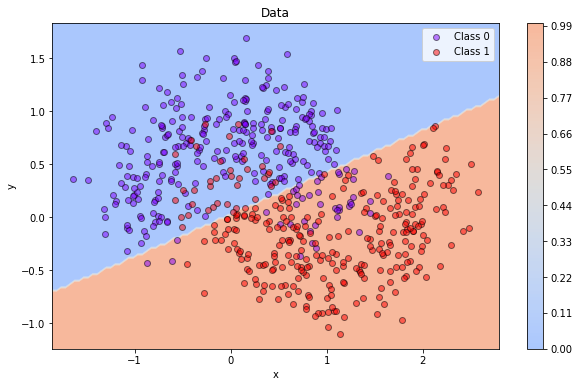

In [ ]:
pl.figure(figsize = (10, 6))
plot_decision_region(X_moons, gen_pred_fun(linear_moons))
plot_data(X_moons, y_moons)

In [ ]:
print("Error en entrenamiento: {}".format(1-linear_moons.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-linear_moons.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.12380952380952381
Error en prueba: 0.15000000000000002


## Kernel polinomial

La función $k$ está definida como:
$$
k(x,y) = (\gamma \langle x, y\rangle + r)^d
$$
dónde $d$ corresponde al grado del polinomio. De manera similar podemos acceder a la implementación de este kernel a través de `sklearn.svm.SVC`. Definimos primero un kernel polinomial de grado 2.

In [ ]:
from sklearn.svm import SVC

poly_svm = SVC(kernel='poly', degree=2, coef0=1)
poly_svm.fit(X_train_moons, y_train_moons);

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


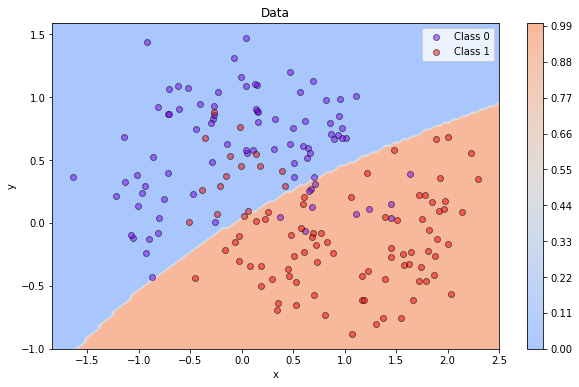

In [ ]:
pl.figure(figsize = (10, 6))
plot_decision_region(X_test_moons, gen_pred_fun(poly_svm))
plot_data(X_test_moons, y_test_moons)

Aunque si lo intentamos con un polinomio de grado $3$:

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


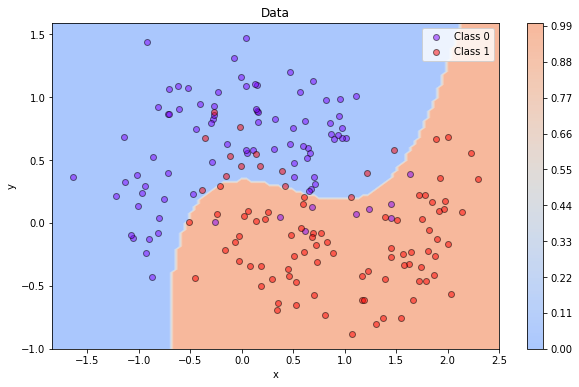

In [ ]:
poly_svm = SVC(kernel='poly', degree=3, coef0=1)
poly_svm.fit(X_train_moons, y_train_moons)

pl.figure(figsize = (10, 6))
plot_decision_region(X_test_moons, gen_pred_fun(poly_svm))
plot_data(X_test_moons, y_test_moons)

Medimos el error en entrenamiento y prueba

In [ ]:
print("Error en entrenamiento: {}".format(1-poly_svm.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-poly_svm.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.09523809523809523
Error en prueba: 0.12777777777777777


Ahora probamos con el conjunto de datos IRIS:

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in cas

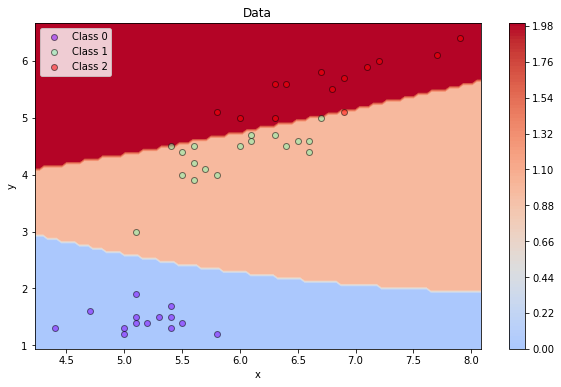

In [ ]:
poly_svm = SVC(kernel='poly', degree=3)
poly_svm.fit(X_train_iris, y_train_iris)

pl.figure(figsize = (10, 6))
plot_decision_region(X_test_iris, gen_pred_fun(poly_svm))
plot_data(X_test_iris, y_test_iris)

In [ ]:
print("Error en entrenamiento: {}".format(1-poly_svm.score(X_train_iris, y_train_iris)))
print("Error en prueba: {}".format(1-poly_svm.score(X_test_iris, y_test_iris)))

Error en entrenamiento: 0.03809523809523807
Error en prueba: 0.022222222222222254


## Kernel Gaussiano


$$
K(x, x') = \exp\left(-\frac{\|x-x'\|^2}{2\sigma^2}\right)
$$
la cual se puede simplificar como
$$
K(x, x') = \exp(-\gamma \|x-x'\|^2)
$$
$$
\gamma \ = \frac{1}{2\sigma^2}
$$
En la literatura este método tambien se encuentra como kernel usando una función de base radial (**RBF** por sus siglas en ingles). En el siguiente ejemplo probamos con un valor de $\gamma$ pequeño:

In [ ]:
rbf_svm = SVC(kernel='rbf', gamma = 0.001)
rbf_svm.fit(X_train_moons, y_train_moons);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


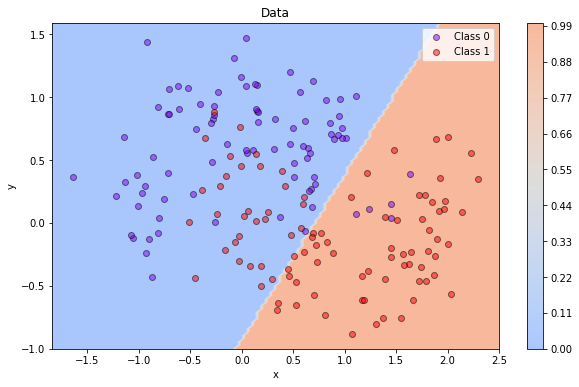

In [ ]:
pl.figure(figsize = (10, 6))
plot_decision_region(X_test_moons, gen_pred_fun(rbf_svm))
plot_data(X_test_moons, y_test_moons)

Reportamos el error de entrenamiento y prueba:

In [ ]:
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.19999999999999996
Error en prueba: 0.21111111111111114


Usamos un $\gamma$ más grande

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


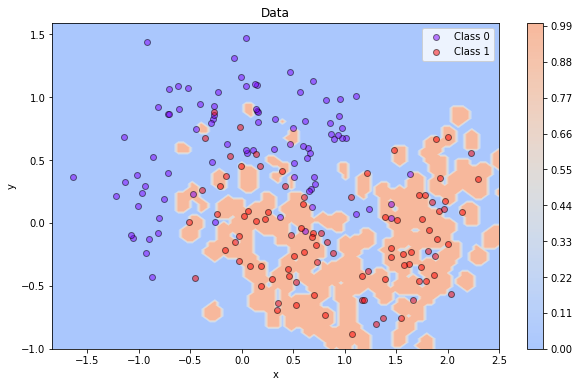

In [ ]:
rbf_svm = SVC(kernel='rbf', gamma = 1000)
rbf_svm.fit(X_train_moons, y_train_moons)

pl.figure(figsize = (10, 6))
plot_decision_region(X_test_moons, gen_pred_fun(rbf_svm))
plot_data(X_test_moons, y_test_moons)

Ahora reportamos el error de entrenamiento y prueba:

In [ ]:
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.0
Error en prueba: 0.22777777777777775


Ahora escogemos un valor de $\gamma$ intermedio

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


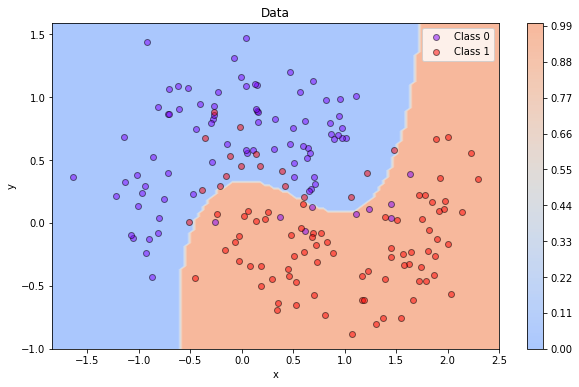

In [ ]:
rbf_svm = SVC(kernel='rbf', gamma = 0.7)
rbf_svm.fit(X_train_moons, y_train_moons)

pl.figure(figsize = (10, 6))
plot_decision_region(X_test_moons, gen_pred_fun(rbf_svm))
plot_data(X_test_moons, y_test_moons)

In [ ]:
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_train_moons, y_train_moons)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_test_moons, y_test_moons)))

Error en entrenamiento: 0.08809523809523812
Error en prueba: 0.1444444444444445


Probamos sobre el conjunto de datos iris

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


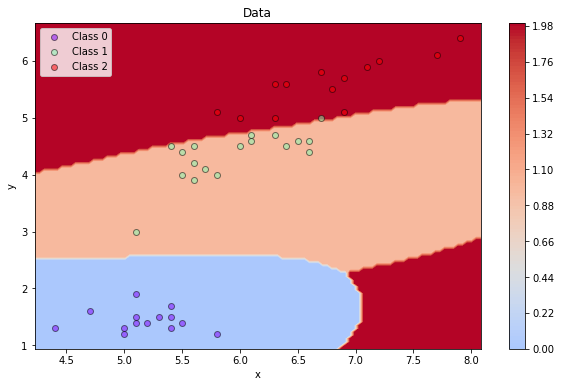

In [ ]:
rbf_svm = SVC(kernel='rbf', gamma = 0.7)
rbf_svm.fit(X_train_iris, y_train_iris)

pl.figure(figsize = (10, 6))
plot_decision_region(X_test_iris, gen_pred_fun(rbf_svm))
plot_data(X_test_iris, y_test_iris)

Finalmente reportamos el error en entrenamiento y prueba:

In [ ]:
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_train_iris, y_train_iris)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_test_iris, y_test_iris)))

Error en entrenamiento: 0.02857142857142858
Error en prueba: 0.022222222222222254


# Estimando de una forma más robusta los hiperparámetros del modelo

Hasta el momento nos hemos concentrado en evaluar nuestros modelos en una partición de prueba. Sin embargo, es común introducir sobreajuste a través de la modificación manual de los hiperparámetros de un modelo conforme vamos reportando el error de generalización sobre el conjunto de prueba.

<img src="https://drive.google.com/uc?export=view&id=1brLudEu094L7H3-cFqnrIRZnDrFIfrNW">

En la anterior imagen, introducimos una nueva partición, conocida como partición de "**validación**". Esta partición es resultado de tomar la partición de entrenamiento y volver a dividirla (en entrenamiento y validación) de tal forma que cualquier configuración de parámetros que se use para entrenar un modelo, pueda ser reportada en **validación**. Una vez estemos seguros que tenemos el modelo con el mejor desempeño en **validación**, volvemos a unir ambas particiones, entrenamos un modelo sobre la partición original de entrenamiento y reportamos **una sola vez** en el conjunto de prueba.

# Validación cruzada de  k pliegues

A pesar de que se introdujo una nueva partición para validar los parámetros de un modelo, se sigue usando una partición reducida para entrenar el conjunto de datos. La validación cruzada nos permite usar una mayor parte de los datos para construír el modelo y generar un estimador más robusto y con mayor capacidad de generalización. En validación cruzada, los datos son particionados varias veces en entrenamiento y validación de forma repetida. Finalmente el desempeño del clasificador es agregado sobre las diferentes particiones de validación para obtener un estimador más robusto.

La validación cruzada se hace comúnmente de la siguiente manera:
* Se divide el conjunto de entrenamiento en k-pliegues o particiones (usualmente 3, 5 o 10).
* Estas particiones deben ser del mismo tamaño
* En cada iteración uno de los pliegues es usado como la partición de validación, mientras el resto es usado como la partición de entrenamiento.
* Se reporta y guarda el desempeño sobre esa partición de validación

<img src="https://drive.google.com/uc?export=view&id=12nCvyPDNOgHuxpToJrlR-m71nt3SOrKo">

## Validación cruzada usando Scikit-Learn

Scikit-Learn provee una implementación muy eficiente para realizar **validación cruzada** usando `sklearn.model_selection`. `sklearn.model_selection.cross_val_score` recibe un estimador y un conjunto de datos, luego
hace el particionamiento y entrena un modelo sobre cada partición de validación.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
X = iris.data
y = iris.target

classifier = LinearSVC()


El parámetro `cv` en `cross_val_score` controla el número de pliegues a usar.

In [ ]:
X = iris.data
y = iris.target

scores = cross_val_score(classifier, X, y, cv=5)
print('Accuracy por cada pliegue: {}'.format(scores))
print('Accuracy promedio sobre los 5 pliegues: {}'.format(np.mean(scores)))

Accuracy por cada pliegue: [1.         1.         0.93333333 0.9        1.        ]
Accuracy promedio sobre los 5 pliegues: 0.9666666666666668


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


`cross_val_score` realiza por defecto una partición estratificada usando `sklearn.model_selection.StratifiedKFold`. Esta estrategia consiste en hacer un particionamiento de tal forma que cada partición tenga la misma distribución de etiquetas $y$. En caso que no se quiera hacer una partición estratificada, se puede usar `sklearn.model_selection.KFold`.

`sklearn.model_selection.StratifiedKFold` genera de forma automática la partición estratificada, sin necesidad de hacer una permutación de los datos como lo hicimos anteriormente. A continuación revisamos los índices que genera `StratifiedKFold`:

In [ ]:
cv = StratifiedKFold(n_splits=5)

for train, val in cv.split(iris.data, iris.target):
    print(val)
    print('Tamaño entrenamiento: {}'.format(len(train)))
    print('Tamaño validación: {}'.format(len(val)))

[  0   1   2   3   4   5   6   7   8   9  50  51  52  53  54  55  56  57
  58  59 100 101 102 103 104 105 106 107 108 109]
Tamaño entrenamiento: 120
Tamaño validación: 30
[ 10  11  12  13  14  15  16  17  18  19  60  61  62  63  64  65  66  67
  68  69 110 111 112 113 114 115 116 117 118 119]
Tamaño entrenamiento: 120
Tamaño validación: 30
[ 20  21  22  23  24  25  26  27  28  29  70  71  72  73  74  75  76  77
  78  79 120 121 122 123 124 125 126 127 128 129]
Tamaño entrenamiento: 120
Tamaño validación: 30
[ 30  31  32  33  34  35  36  37  38  39  80  81  82  83  84  85  86  87
  88  89 130 131 132 133 134 135 136 137 138 139]
Tamaño entrenamiento: 120
Tamaño validación: 30
[ 40  41  42  43  44  45  46  47  48  49  90  91  92  93  94  95  96  97
  98  99 140 141 142 143 144 145 146 147 148 149]
Tamaño entrenamiento: 120
Tamaño validación: 30


Usando una función definida previamente, vamos a validar la distribución de las etiquetas por clase.

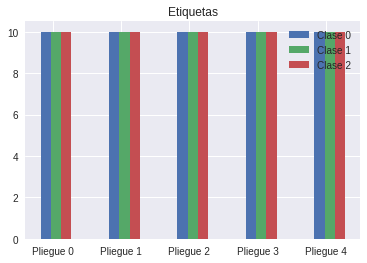

In [ ]:
n_folds = 5
cv_str = StratifiedKFold(n_splits=n_folds)
y = iris.target

y_labels = []
for _, val in cv_str.split(iris.data, iris.target):
    y_labels.append(y[val])

plot_labels(n_folds, 3, y_labels)

In [ ]:
scores = cross_val_score(classifier, X, y, cv=cv_str)
print('Accuracy por cada pliegue: {}'.format(scores))
print('Accuracy promedio sobre los 5 pliegues: {}'.format(np.mean(scores)))

Accuracy por cada pliegue: [1.         1.         0.93333333 0.9        1.        ]
Accuracy promedio sobre los 5 pliegues: 0.9666666666666668


Por otro lado, usando `KFold` podemos obtener un particionamiento de tantos pliegues como se especifiquen. Sin embargo, se corre el riesgo de no generar particiones balanceadas, por lo tanto lo estimadores no van a tener el desempeño esperado. Por ejemplo en el **Pliegue 0** solo hay datos de la clase $0$.

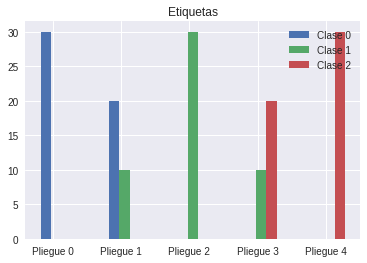

In [ ]:
n_folds = 5
cv_nostr = KFold(n_splits=n_folds)
y = iris.target

y_labels = []
for _, val in cv_nostr.split(iris.data, iris.target):
    y_labels.append(y[val])

plot_labels(n_folds, 3, y_labels)

In [ ]:
scores = cross_val_score(classifier, X, y, cv=cv_nostr)
print('Accuracy por cada pliegue: {}'.format(scores))
print('Accuracy promedio sobre los 5 pliegues: {}'.format(np.mean(scores)))

Accuracy por cada pliegue: [1.         1.         0.66666667 0.96666667 0.66666667]
Accuracy promedio sobre los 5 pliegues: 0.86


# Grid search

SVM usando RBF comúnmente requiere el ajuste de dos parámetros:
* `gamma`
* `C`

Ambos parámetros pueden ser explorados usando un retículo (grid) de parámetros y evaluando su desempeño usando validación cruzada de $k$ pliegues. A continuación, creamos una partición entrenamiento y prueba sobre el conjunto de datos IRIS.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Definimos los siguientes valores para $C$ y $\textit{gamma}$.

In [ ]:
grid = [i for i in range(-5, 7, 1)]
param_grid = {'C': [2**i for i in grid], 'gamma': [2**i for i in grid]}

Valores de $C$:

In [ ]:
print(param_grid['C'])

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


Valores de $\textit{gamma}$:

In [ ]:
print(param_grid['gamma'])

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


In [ ]:
param_grid

{'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64],
 'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]}

`GridSearchCV` recibe dos elementos fundamentales:
* `estimator`: Modelo de Scikit-Learn. Puede ser `SVC(kernel='rbf')`.
* `param_grid`: Diccionario que contiene los parámetros que se van a explorar usando validación cruzada.

In [ ]:
clf = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, verbose=2, return_train_score=True)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......................... C=0.03125, gamma=0.03125, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.0625 .........................................
[CV] .......................... C=0.03125, gamma=0.0625, total=   0.0s
[CV] C=0.03125, gamma=0.125 ..........................................
[CV] .........

[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64], 'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

Los valores promedio de accuracy para cada combinación de hiperparámetros se pueden extraer usando `GridSearchCV.cv_results_`. Convertimos ese diccionario a un DataFrame de pandas.

In [ ]:
import pandas as pd

cv_results = pd.DataFrame(clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.001707,0.001333,0.000374,0.000050,0.03125,0.03125,"{'C': 0.03125, 'gamma': 0.03125}",0.694444,0.342857,0.352941,0.466667,0.164578,127,0.695652,0.357143,0.352113,0.468303,0.160774
1,0.000834,0.000166,0.000325,0.000007,0.03125,0.0625,"{'C': 0.03125, 'gamma': 0.0625}",0.694444,0.685714,0.705882,0.695238,0.008194,105,0.695652,0.700000,0.690141,0.695264,0.004034
2,0.000705,0.000161,0.000329,0.000013,0.03125,0.125,"{'C': 0.03125, 'gamma': 0.125}",0.694444,0.685714,0.705882,0.695238,0.008194,105,0.695652,0.700000,0.690141,0.695264,0.004034
3,0.000685,0.000096,0.000313,0.000015,0.03125,0.25,"{'C': 0.03125, 'gamma': 0.25}",0.694444,0.685714,0.705882,0.695238,0.008194,105,0.695652,0.700000,0.690141,0.695264,0.004034
4,0.000695,0.000171,0.000313,0.000012,0.03125,0.5,"{'C': 0.03125, 'gamma': 0.5}",0.694444,0.600000,0.647059,0.647619,0.038829,111,0.695652,0.685714,0.647887,0.676418,0.020578
5,0.000728,0.000104,0.000324,0.000006,0.03125,1,"{'C': 0.03125, 'gamma': 1}",0.694444,0.342857,0.352941,0.466667,0.164578,127,0.695652,0.357143,0.352113,0.468303,0.160774
6,0.000677,0.000099,0.000327,0.000009,0.03125,2,"{'C': 0.03125, 'gamma': 2}",0.694444,0.342857,0.352941,0.466667,0.164578,127,0.681159,0.357143,0.352113,0.463472,0.153942
7,0.000780,0.000233,0.000307,0.000011,0.03125,4,"{'C': 0.03125, 'gamma': 4}",0.666667,0.342857,0.352941,0.457143,0.151397,130,0.652174,0.357143,0.352113,0.453810,0.140280
8,0.000595,0.000007,0.000311,0.000009,0.03125,8,"{'C': 0.03125, 'gamma': 8}",0.638889,0.342857,0.352941,0.447619,0.138218,131,0.637681,0.357143,0.352113,0.448979,0.133448
9,0.000608,0.000010,0.000318,0.000009,0.03125,16,"{'C': 0.03125, 'gamma': 16}",0.611111,0.342857,0.352941,0.438095,0.125039,133,0.695652,0.357143,0.352113,0.468303,0.160774


A continuación, observamos que el número de filas de ese DataFrame corresponde al número de configuraciones de hiperparámetros que se están explorando:

In [ ]:
print(len(cv_results))
print(len(param_grid['C'])*len(param_grid['gamma']))

144
144


Usando la columna `mean_test_score`, extraemos los accuracy promedio de la siguiente forma:

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']),
                                                    len(param_grid['gamma']))

In [ ]:
scores

array([[0.46666667, 0.6952381 , 0.6952381 , 0.6952381 , 0.64761905,
        0.46666667, 0.46666667, 0.45714286, 0.44761905, 0.43809524,
        0.43809524, 0.35238095],
       [0.6952381 , 0.6952381 , 0.71428571, 0.75238095, 0.82857143,
        0.74285714, 0.63809524, 0.48571429, 0.44761905, 0.43809524,
        0.43809524, 0.35238095],
       [0.6952381 , 0.76190476, 0.92380952, 0.94285714, 0.93333333,
        0.92380952, 0.87619048, 0.64761905, 0.5047619 , 0.43809524,
        0.43809524, 0.35238095],
       [0.82857143, 0.93333333, 0.95238095, 0.96190476, 0.96190476,
        0.96190476, 0.95238095, 0.93333333, 0.62857143, 0.51428571,
        0.43809524, 0.35238095],
       [0.94285714, 0.96190476, 0.96190476, 0.97142857, 0.96190476,
        0.96190476, 0.95238095, 0.95238095, 0.9047619 , 0.62857143,
        0.51428571, 0.36190476],
       [0.96190476, 0.96190476, 0.97142857, 0.97142857, 0.97142857,
        0.97142857, 0.97142857, 0.96190476, 0.93333333, 0.83809524,
        0.71428571,

A continuación, presentamos una forma de visualizar esta exploración sobre la malla de hiperparámetros

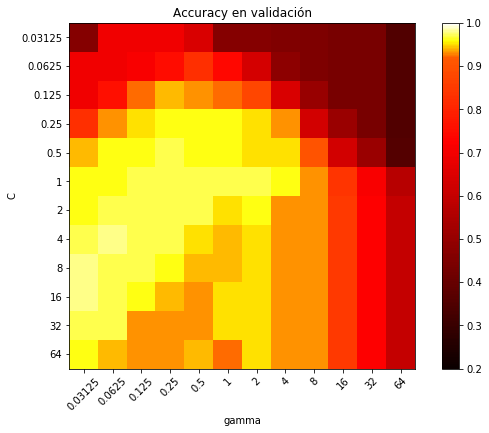

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92, vmax=1.))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Accuracy en validación')
plt.show()

Encontramos que existen tres modelos con el mejor desempeño usando validación cruzada:
* $C=4$ y $\gamma=0.0625$
* $C=8$ y $\gamma=0.03125$
* $C=16$ y $\gamma=0.03125$

Para validar esta información, `GridSearchCV` nos ofrece una serie de métodos que nos permite consultar:
* La lista de resultados por elemento en la malla de parámetros (`cv_results_`)
* La configuración con el mejor desempeño (`best_params_`)
* El accuracy promediado sobre todos los pliegues de la mejor configuración (`best_score_`)

Para encontrar las mejores configuraciones, ordenamos la tabla de resultados de la siguiente manera:

In [ ]:
cv_results = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
cv_results.sort_values(by='mean_test_score', ascending=False).head()

,param_C,param_gamma,mean_test_score
96,8,0.03125,0.980952
85,4,0.0625,0.980952
108,16,0.03125,0.980952
97,8,0.0625,0.971429
87,4,0.25,0.971429


Esta información también se puede consultar usando `.best_params_` y `.best_score_`.

In [ ]:
print(clf.best_params_)

{'C': 4, 'gamma': 0.0625}


In [ ]:
print(clf.best_score_)

0.9809523809523809


Una vez se haya entrenado el modelo usando validación cruzada, `GridSearchCV` escoge automáticamente la mejor configuración y vuelve a entrenar un modelo sobre todo el conjunto de datos de entrenamiento. Por lo tanto se pueden hacer llamados a funciones como `predict()` y `score()`.

Para reportar sobre el conjunto de prueba basta con:

In [ ]:
clf.score(X_test, y_test)

0.9777777777777777